# 1. IMPORT DATASETS AND LIBRARIES


In [59]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras


In [60]:
!pip install yfinance --upgrade --no-cache-dir -q

In [61]:
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime, timedelta

yf.pdr_override() # download data faster

start_date = '2010-01-01'
today_date = datetime.today().strftime('%Y-%m-%d')
print('Today\'s date: ', today_date)
tomorrow_date = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')

# download dataframe
ticker = "IVV"
raw_price_df = pdr.get_data_yahoo(ticker, start = start_date, end = tomorrow_date)

Today's date:  2023-08-21
[*********************100%%**********************]  1 of 1 completed


In [62]:
# Sort the data based on Date
price_df_sorted = raw_price_df.sort_values(by = ['Date'])
price_df_sorted

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.769997,113.739998,112.709999,113.650002,88.135696,3574200
2010-01-05,113.620003,114.029999,113.250000,113.980003,88.391594,2784100
2010-01-06,113.889999,114.339996,113.790001,114.070000,88.461411,3912800
2010-01-07,113.870003,114.669998,113.550003,114.570000,88.849136,2977600
2010-01-08,114.230003,114.970001,114.010002,114.959999,89.151573,2887600
...,...,...,...,...,...,...
2023-08-15,448.690002,448.980011,444.649994,445.339996,445.339996,5019300
2023-08-16,444.820007,446.529999,441.869995,442.010010,442.010010,2896100
2023-08-17,443.450012,443.760010,438.070007,438.609985,438.609985,3991000


In [63]:
price_df_sorted.shape

(3431, 6)

# 2. PERFORM EXPLORATORY DATA ANALYSIS AND VISUALIZATION

In [64]:
# Check if Null values exist in stock prices data
price_df_sorted.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [65]:
# Get stock prices dataframe info
price_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3431 entries, 2010-01-04 to 2023-08-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3431 non-null   float64
 1   High       3431 non-null   float64
 2   Low        3431 non-null   float64
 3   Close      3431 non-null   float64
 4   Adj Close  3431 non-null   float64
 5   Volume     3431 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 187.6 KB


In [66]:
price_df_sorted.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3431.000000,3431.000000,3431.000000,3431.000000,3431.000000,3.431000e+03
mean,249.447470,250.778680,247.977744,249.488756,228.048708,4.331893e+06
std,103.718048,104.370323,103.037607,103.730570,110.446958,2.448124e+06
min,103.480003,103.769997,88.419998,102.599998,80.264153,9.955000e+05
25%,164.055000,164.915001,163.224998,164.090004,135.998444,2.833350e+06
50%,219.360001,219.880005,218.639999,219.399994,193.250473,3.751300e+06
75%,313.845001,314.610001,311.955002,313.300003,296.526215,5.050050e+06
max,481.369995,482.070007,478.119995,479.839996,468.844910,3.874850e+07


In [67]:
# price_df_sorted.filter(['Close'])

In [68]:
price_df = price_df_sorted.reset_index()[['Date', 'Close']]
price_df

,Date,Close
0,2010-01-04,113.650002
1,2010-01-05,113.980003
2,2010-01-06,114.070000
3,2010-01-07,114.570000
4,2010-01-08,114.959999
...,...,...
3426,2023-08-15,445.339996
3427,2023-08-16,442.010010
3428,2023-08-17,438.609985
3429,2023-08-18,438.690002


In [69]:
# Function to normalize stock prices based on their initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

In [70]:
# Function to plot interactive plots using Plotly Express
def interactive_plot(fig, df):
  for i in df.columns:
    if i != 'Date':
      fig.add_scatter(x = df['Date'], y = df[i], name = i)

In [71]:
# plot interactive chart for stocks data
import plotly.graph_objs as go

# create initial figure object
original_price_fig = go.Figure()
original_price_fig.update_layout(title = f'{ticker}Stock Price History', xaxis_title = 'Date', yaxis_title = 'Close Price USD ($)')

# plot initial data
interactive_plot(original_price_fig, price_df)
original_price_fig.show()


# 3. PREPARE THE DATA BEFORE TRAINING THE AI/ML MODEL

### Convert the dataframe into array format

In [72]:
# # filter dataframe based on date
# filtered_df = price_df.loc[price_df['Date'] >= '2021-05-28']
# filtered_df

In [73]:
price_df

,Date,Close
0,2010-01-04,113.650002
1,2010-01-05,113.980003
2,2010-01-06,114.070000
3,2010-01-07,114.570000
4,2010-01-08,114.959999
...,...,...
3426,2023-08-15,445.339996
3427,2023-08-16,442.010010
3428,2023-08-17,438.609985
3429,2023-08-18,438.690002


In [74]:
price_array = np.array(price_df['Close']).reshape(-1,1)
price_array.shape

(3431, 1)

### Splitting the dataset into the Training set and Test set

In [75]:
# splitting dataset into train and test split this way, since order is important in time-series
# dont use train test split with it's default settings since it shuffles the data
def split_X_train_test(X, test_size=0.2):
  split = int((1-test_size) * len(X)) # round up the number
  X_train = X[:split]
  X_test = X[split:]

  return X_train, X_test

X_train_unscaled, X_test_unscaled = split_X_train_test(price_array, 0.01)

### Time steps

In [76]:
time_steps = 60

### Add time steps for first X_test input

In [77]:
X_train_len = X_train_unscaled.shape[0]

In [78]:
X_train_unscaled.shape, X_test_unscaled.shape

((3396, 1), (35, 1))

In [79]:
X_train_unscaled[-1], X_test_unscaled[0]

(array([445.70999146]), array([446.3500061]))

In [80]:
X_test_unscaled = np.concatenate((X_train_unscaled[-time_steps:], X_test_unscaled), axis=0)

In [81]:
X_test_unscaled.shape, X_test_unscaled[time_steps-1:time_steps+1]

((95, 1),
 array([[445.70999146],
        [446.3500061 ]]))

### Feature Scaling for NN


In [82]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler (output = np.array format)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = sc.fit_transform(X_train_unscaled)
X_test_scaled = sc.transform(X_test_unscaled)

In [83]:
X_train_scaled, X_train_scaled.shape

(array([[0.02929171],
        [0.03016649],
        [0.03040505],
        ...,
        [0.89057364],
        [0.8952126 ],
        [0.90952708]]),
 (3396, 1))

In [84]:
X_test_scaled, X_test_scaled.shape

(array([[0.8134344 ],
        [0.81754324],
        [0.81878914],
        [0.8187626 ],
        [0.8146803 ],
        [0.82883573],
        [0.82613191],
        [0.83018768],
        [0.83082386],
        [0.83074434],
        [0.82456793],
        [0.82517765],
        [0.82655606],
        [0.80911353],
        [0.80471322],
        [0.82607893],
        [0.83517126],
        [0.83437596],
        [0.82199662],
        [0.81412365],
        [0.80654222],
        [0.82626442],
        [0.82684761],
        [0.8223677 ],
        [0.8269802 ],
        [0.8253367 ],
        [0.82390522],
        [0.82753685],
        [0.82019408],
        [0.83344824],
        [0.84415754],
        [0.84254057],
        [0.84285866],
        [0.83066481],
        [0.82239423],
        [0.8320433 ],
        [0.84654336],
        [0.84675539],
        [0.83986321],
        [0.85131482],
        [0.86732587],
        [0.8653642 ],
        [0.86777647],
        [0.86048668],
        [0.86703424],
        [0

### Creating the datasets with timesteps input

In [85]:
import numpy as np

# convert an array of values into a dataset matrix
def create_dataset(array_data, time_steps=1):

  X, y = [], [] # become a list

  for i in range(time_steps, len(array_data)):
      X.append(array_data[i-time_steps:i, 0]) # its a 2D array => [row, col]
      y.append(array_data[i, 0])

  # return the new dataset
  return np.array(X), np.array(y) # convert into np array for RNN inputs

X_train, y_train = create_dataset(X_train_scaled, time_steps)
X_test, y_test = create_dataset(X_test_scaled, time_steps)

In [86]:
X_train.shape, y_train.shape

((3336, 60), (3336,))

In [87]:
X_test.shape, y_test.shape

((35, 60), (35,))

### Reshaping to 3D tensor for RNN input format

In [88]:
  # RNN input params = (batch size, timesteps, features/indicators)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # add a new dimensionality to be compatible with the 3D tensor input shape of RNN and allow more indicators
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [89]:
X_train.shape, y_train.shape

((3336, 60, 1), (3336,))

In [90]:
X_test.shape, y_test.shape

((35, 60, 1), (35,))

# 4. Building and Training the RNN

### load the model from google drive

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
# from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/Projects/Stock Trend Prediction/best_model.h5')

In [93]:

from keras.models import Sequential # allow us to build a NN object representing a sequence of layers
from keras.layers import Dense # add the output layer
from keras.layers import LSTM # add the LSTM layers
from keras.layers import Dropout # add dropout regularization

In [94]:
# Create the model
model = Sequential() # regression -- predicting continuous values
model.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units = 150, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 150))
model.add(Dense(units = 1)) # dense class to create the fully-connected layer to fully connect the previous LSTM layer to one output unit

model.compile(optimizer='adam', loss="mean_squared_error")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 150)           91200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 150)           0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 150)           180600    
                                                                 
 dropout_3 (Dropout)         (None, 60, 150)           0         
                                                                 
 lstm_5 (LSTM)               (None, 150)               180600    
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 452,551
Trainable params: 452,551
Non-tr

In [95]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', verbose=1, patience=30)
file_path = f'/content/drive/MyDrive/Projects/Stock Trend Prediction/{ticker}_model.h5'
mc = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True)

# fit model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[es, mc])

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.0104
Epoch 1: val_loss improved from inf to 0.00146, saving model to /content/drive/MyDrive/Projects/Stock Trend Prediction/IVV_model.h5
42/42 [==============================] - 30s 619ms/step - loss: 0.0104 - val_loss: 0.0015
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 4.4856e-04
Epoch 2: val_loss did not improve from 0.00146
42/42 [==============================] - 15s 348ms/step - loss: 4.4856e-04 - val_loss: 0.0015
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 4.0652e-04
Epoch 3: val_loss improved from 0.00146 to 0.00122, saving model to /content/drive/MyDrive/Projects/Stock Trend Prediction/IVV_model.h5
42/42 [==============================] - 14s 336ms/step - loss: 4.0652e-04 - val_loss: 0.0012
Epoch 4/100
42/42 [==============================] - ETA: 0s - loss: 3.8846e-04
Epoch 4: val_loss improved from 0.00122 to 0.00089, saving model to /content/drive/MyDrive/

dict_keys(['loss', 'val_loss'])


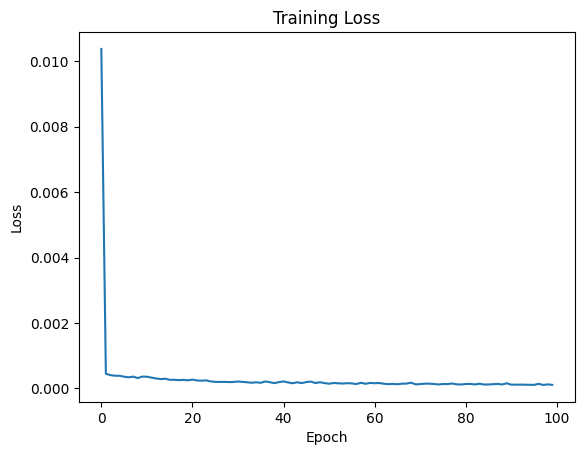

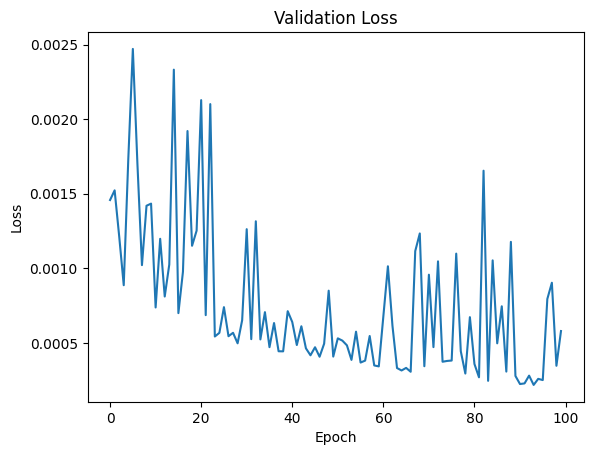

In [96]:
print(history.history.keys())

# Plot the training loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [97]:
train_accuracy = model.evaluate(X_train, y_train, verbose=1)
print('train accuracy: ', train_accuracy)
test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('test accuracy: ', test_accuracy)

105/105 [==============================] - 8s 74ms/step - loss: 1.7177e-04
train accuracy:  0.00017176545225083828
2/2 [==============================] - 0s 17ms/step - loss: 8.9486e-04
test accuracy:  0.0008948622271418571


### Hyperparameter Tuning

In [98]:
# import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import itertools


# def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):

#     first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
#     possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
#                                                   n_neurons, n_batch_size, dropout))

#     print(possible_combinations)
#     print('\n')

#     hist = []

#     for i in range(0, len(possible_combinations)):

#         print(f'{i+1}th combination: \n')
#         print('--------------------------------------------------------------------')

#         first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

#         # instantiating the model in the strategy scope creates the model on the TPU
#         #with tpu_strategy.scope():
#         regressor = Sequential()
#         regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
#         regressor.add(Dropout(dropout))

#         if first_additional_layer:
#             regressor.add(LSTM(units=n_neurons, return_sequences=True))
#             regressor.add(Dropout(dropout))

#         if second_additional_layer:
#             regressor.add(LSTM(units=n_neurons, return_sequences=True))
#             regressor.add(Dropout(dropout))

#         if third_additional_layer:
#             regressor.add(LSTM(units=n_neurons, return_sequences=True))
#             regressor.add(Dropout(dropout))

#         regressor.add(LSTM(units=n_neurons, return_sequences=False))
#         regressor.add(Dropout(dropout))
#         regressor.add(Dense(units=1, activation='linear'))
#         regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

#         es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#         '''''
#         From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
#         alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
#         '''''

#         file_path = '/content/drive/MyDrive/Projects/Stock Trend Prediction/best_model.h5'

#         mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

#         '''''
#         cb = Callback(...)  # First, callbacks must be instantiated.
#         cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
#         model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
#         '''''

#         regressor.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

#         # load the best model
#         # regressor = load_model('best_model.h5')

#         train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
#         test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

#         hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
#                           train_accuracy, test_accuracy)))

#         print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')

#     return hist

In [99]:
# config = [[False, True], [False, True], [False, True], [16, 32], [8, 16, 32], [0.2]]

# # list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

# hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

In [100]:
# hist = pd.DataFrame(hist)
# hist = hist.sort_values(by=[7], ascending=True)
# hist

# 5. Plot the predictions

In [101]:
# Make prediction
scaled_predictions = model.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [102]:
predictions_array = sc.inverse_transform(scaled_predictions)
predictions_array.shape

(35, 1)

In [103]:
y_test = sc.inverse_transform(y_test.reshape(-1,1))

In [104]:
predictions_array.reshape(-1).shape, y_test.reshape(-1).shape

((35,), (35,))

In [105]:
# Get the RMSE
rmse = np.sqrt(((predictions_array - y_test) ** 2).mean())
rmse

11.284867961977032

In [106]:
# Append the predicted values to the list
predictions_list = []

for i in predictions_array:
  predictions_list.append(i[0])

len(predictions_list)

35

In [107]:
train_df = price_df[:X_train_len]
train_df = train_df.rename(columns={'Close': 'Previous Prices'})

valid_df = price_df[X_train_len:]
valid_df = valid_df.rename(columns={'Close': 'Actual Closing Price'})
valid_df['Next Day Prediction'] = predictions_list

In [108]:
valid_df

,Date,Actual Closing Price,Next Day Prediction
3396,2023-07-03,446.350006,433.522491
3397,2023-07-05,445.579987,435.807343
3398,2023-07-06,441.929993,436.062012
3399,2023-07-07,440.799988,433.673767
3400,2023-07-10,441.970001,431.315338
3401,2023-07-11,444.940002,430.814850
3402,2023-07-12,448.279999,432.602112
3403,2023-07-13,452.100006,435.786743
3404,2023-07-14,451.649994,439.646057
3405,2023-07-17,453.329987,441.287140


In [109]:
train_df

,Date,Previous Prices
0,2010-01-04,113.650002
1,2010-01-05,113.980003
2,2010-01-06,114.070000
3,2010-01-07,114.570000
4,2010-01-08,114.959999
...,...,...
3391,2023-06-26,433.619995
3392,2023-06-27,438.420013
3393,2023-06-28,438.559998
3394,2023-06-29,440.309998


In [110]:
# Plot the data
prediction_fig = go.Figure()
prediction_fig.update_layout(title = f"{ticker} Stock Trend Forecast", xaxis_title = 'Date', yaxis_title = 'Close Price USD ($)')

interactive_plot(prediction_fig, train_df)
interactive_plot(prediction_fig, valid_df)
prediction_fig.show()

# 6. Check Next day prediction

### Check date US stock market open day

In [111]:
from datetime import datetime, timedelta

def get_previous_and_next_open_days(date_str):
    # Convert the input date string to a datetime object
    date = datetime.strptime(date_str, '%Y-%m-%d').date()

    # Define a list of public holidays
    public_holidays = [
        datetime(2023, 1, 2),   # New Year's Day (observed)
        datetime(2023, 1, 16),  # Martin Luther King Jr. Day
        datetime(2023, 2, 20),  # Presidents' Day
        datetime(2023, 4, 14),  # Good Friday
        datetime(2023, 5, 29),  # Memorial Day
        datetime(2023, 7, 4),   # Independence Day (observed)
        datetime(2023, 9, 4),   # Labor Day
        datetime(2023, 11, 23), # Thanksgiving Day
        datetime(2023, 12, 25)  # Christmas Day
    ]

    previous_open_day = date
    next_open_day = date

    # Calculate the previous and next available stock market open days
    if date.weekday() in [5, 6] or date in public_holidays:
        while previous_open_day.weekday() in [5, 6] or previous_open_day in public_holidays:
            previous_open_day -= timedelta(days=1)

        while next_open_day.weekday() in [5, 6] or next_open_day in public_holidays:
            next_open_day += timedelta(days=1)

    elif date.weekday() == 4:
        previous_open_day -= timedelta(days=1)
        next_open_day += timedelta(days=3)

    elif date.weekday() == 0:
        previous_open_day -= timedelta(days=3)
        next_open_day += timedelta(days=1)

    else:
        previous_open_day -= timedelta(days=1)
        next_open_day += timedelta(days=1)

    # Return the previous and next available stock market open days as strings
    return previous_open_day.strftime('%Y-%m-%d'), next_open_day.strftime('%Y-%m-%d')

### Get a quote

In [112]:
import math

# Get the latest data, predicting yesterday's price
start_date = (datetime.today() - timedelta(days=(time_steps + math.ceil(time_steps/30 * 20 )))).strftime('%Y-%m-%d')
today_date = datetime.today().today().strftime('%Y-%m-%d')
prev_date, next_date = get_previous_and_next_open_days(today_date)
latest_df = pdr.get_data_yahoo(ticker, start = start_date, end = prev_date)
print('Dataset\'s Start date: ', start_date)
print('Today: ', today_date)
print('Yesterday: ', prev_date)
print('Tomorrow: ', next_date)
# print(latest_df.shape)

# Create a new dataframe
time_steps_df_sorted = latest_df.sort_values(by = ['Date'])
time_steps_df = time_steps_df_sorted.reset_index()[['Close']]
# Get the last 150 days closing price values and convert the dataframe to an array
time_steps_array = np.array(time_steps_df['Close'][-time_steps:]).reshape(-1,1)
# print(time_steps_array.shape)
# Normalization
X_test_quote = sc.transform(time_steps_array)
# Reshape the data
X_test_quote = np.reshape(X_test_quote, (1, X_test_quote.shape[0], X_test_quote.shape[1]))
# Get the predicted price
pred_quote = model.predict(X_test_quote)
# Unscaled
pred_quote = sc.inverse_transform(pred_quote)

print(f'{prev_date} predicted price: ', pred_quote[0][0])

[*********************100%%**********************]  1 of 1 completed
Dataset's Start date:  2023-05-13
Today:  2023-08-21
Yesterday:  2023-08-18
Tomorrow:  2023-08-22
1/1 [==============================] - 0s 23ms/step
2023-08-18 predicted price:  429.4106


In [113]:
quote = pdr.get_data_yahoo(ticker, start = prev_date, end = today_date)
quote['Close']

[*********************100%%**********************]  1 of 1 completed


Date
2023-08-18    438.690002
Name: Close, dtype: float64

# 7. Forecast Trend for the next 10 days

In [114]:
import pandas as pd
import numpy as np


# No. of days for price prediction
pred_days = 100

input_df = price_df.iloc[:X_train_len]
input_df = input_df.iloc[-time_steps:]
date = (input_df.iloc[-1]['Date']).strftime('%Y-%m-%d')
print('Previous Open Day: ', date, '\n')
print(input_df,'\n')
input_array = np.array(input_df['Close']).reshape(-1,1)

output_df = pd.DataFrame({'Date': [], 'Actual Closing Price': [], f'Next {pred_days} days Forecast': []})

# Normalization
input_array = sc.transform(input_array)
# print(type(input_array), input_array.shape)


date_array = pd.to_datetime(price_df['Date'].values).strftime('%Y-%m-%d').values
# Loop over the prediction period and add new rows to the input data for each day
for i in range(pred_days):
  X_input = input_array[-time_steps:]

  # Reshape the data
  X_input_3D = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))

  # Get the scaled predicted price
  output_scaled = model.predict(X_input_3D)

  # add new row to existing input data for prediction
  # print(f"input_array shape: {input_array.shape}, output_scaled shape: {output_scaled.shape}")
  input_array = np.vstack((input_array, output_scaled))

  # Unscaled
  output = sc.inverse_transform(output_scaled)

  # get tmr date
  _, date = get_previous_and_next_open_days(date)
  print(f'Predicted price on {date}: {output[0][0]}')

  # Get closing price on specific date
  if date in date_array:
    # If the search date exists, get its corresponding 'close' column data
    close_data = price_df.loc[price_df['Date'] == date, 'Close'].values[0]
  else:
    close_data = np.nan

  # Create a new row for the current day
  new_row = {'Date': date, 'Actual Closing Price': close_data, f'Next {pred_days} days Forecast': output[0][0]}

  # Append the new row to the input data DataFrame
  output_df = pd.concat([output_df, pd.DataFrame([new_row])], ignore_index=True)

print(output_df)
print(price_df.iloc[X_train_len:])

Previous Open Day:  2023-06-30 

           Date       Close
3336 2023-04-05  409.459991
3337 2023-04-06  411.010010
3338 2023-04-10  411.480011
3339 2023-04-11  411.470001
3340 2023-04-12  409.929993
3341 2023-04-13  415.269989
3342 2023-04-14  414.250000
3343 2023-04-17  415.779999
3344 2023-04-18  416.019989
3345 2023-04-19  415.989990
3346 2023-04-20  413.660004
3347 2023-04-21  413.890015
3348 2023-04-24  414.410004
3349 2023-04-25  407.829987
3350 2023-04-26  406.170013
3351 2023-04-27  414.230011
3352 2023-04-28  417.660004
3353 2023-05-01  417.359985
3354 2023-05-02  412.690002
3355 2023-05-03  409.720001
3356 2023-05-04  406.859985
3357 2023-05-05  414.299988
3358 2023-05-08  414.519989
3359 2023-05-09  412.829987
3360 2023-05-10  414.570007
3361 2023-05-11  413.950012
3362 2023-05-12  413.410004
3363 2023-05-15  414.779999
3364 2023-05-16  412.010010
3365 2023-05-17  417.010010
3366 2023-05-18  421.049988
3367 2023-05-19  420.440002
3368 2023-05-22  420.559998
3369 2023-05-23

### Check RMSE for the test data

In [115]:
rmse_forecast_df = output_df.dropna()
print(rmse_forecast_df)

rmse_pred_trend = np.sqrt(((rmse_forecast_df['Actual Closing Price'].values - rmse_forecast_df[f'Next {pred_days} days Forecast'].values) ** 2).mean())
print(f'RMSE for the above days: ', rmse_pred_trend)

          Date  Actual Closing Price  Next 100 days Forecast
0   2023-07-03            446.350006              433.522522
2   2023-07-05            445.579987              422.853058
3   2023-07-06            441.929993              416.251678
4   2023-07-07            440.799988              409.726868
5   2023-07-10            441.970001              403.522461
6   2023-07-11            444.940002              397.756134
7   2023-07-12            448.279999              392.475739
8   2023-07-13            452.100006              387.677734
9   2023-07-14            451.649994              383.342224
10  2023-07-17            453.329987              379.448151
11  2023-07-18            456.619995              375.985291
12  2023-07-19            457.459991              372.950531
13  2023-07-20            454.609985              370.351044
14  2023-07-21            454.600006              368.203430
15  2023-07-24            456.609985              366.512512
16  2023-07-25          

In [116]:
pred_output_df = output_df.drop('Actual Closing Price', axis = 1)
interactive_plot(prediction_fig, pred_output_df)
prediction_fig.show()